# **Modeling by Precinct:**

The purpose of this notebook is to import the cleaned data from the EDA notebook and build a model to predict the number of 911 calls per precinct by any given hour.<br><br>

The first part of this notebook will be creating a subset of the data aggregated by hour and precinct/burrow.

In [42]:
#import libraries used in this notebook
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
#from tabulate import tabulate #not really plotting but pretty displaying

#stats
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools

#Sklearn
from sklearn.metrics import root_mean_squared_error # type: ignore

#Facebook Profit
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
#from fbprophet.diagnostics import cross_validation, performance_metrics

#pickle
import pickle

#Math
from datetime import timedelta

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [43]:
#Importing data and cleaning index
df_hourly = pd.read_csv(r"C:\Users\cmphi\Documents\BrainStation\DataBases\capstone_911\hourly_df.csv", parse_dates=['Unnamed: 0'])

#renaming and setting index to the datetime
df_hourly.set_index("Unnamed: 0", inplace=True)
df_hourly.index.name = None
df_hourly.head()

1   5   6   7   9  10  13  14  17  18  19  20  22  23  \
2018-01-01 00:00:00   7   6  10  11  17   9  13  27   5  20  11   6   0   9   
2018-01-01 01:00:00  14  16  23  13  24  18  24  33  13  27  16   6   0  10   
2018-01-01 02:00:00  21  16  29  14  20  13  18  35  14  32  12   7   2  14   
2018-01-01 03:00:00  16   8  12  15  14  18  14  28  13  26   7   4   0   6   
2018-01-01 04:00:00  11   7   9   5   8   9  10  18   9  20   6   8   0   7   

                     24  25  26  28  30  32  33  34  40  41  42  43  44  45  \
2018-01-01 00:00:00   8   7   5  11   2   9   9   7  14   9  10  20  23  10   
2018-01-01 01:00:00  15   9   8  11   5  14   7  13  30   7  12  19  21  18   
2018-01-01 02:00:00  10  14  10  13   8   7  13  14  26   6   6  14  18   7   
2018-01-01 03:00:00  12   7   1  10   5   9  13  16  19  10  10  15  15   8   
2018-01-01 04:00:00   9  10   8   4   6  14  10  10  17  13   8  20  17  10   

                     46  47  48  49  50  52  60  61  62  63  66  67  68  69  \
2018-01-01 00:00:00  15  17   6   8   7   8  11  13  15   5  14  21   9   8   
2018-01-01 01:00:00  26  13  15   9   9  21   5  15  14  17   9  15  14   6   
2018-01-01 02:00:00  20  20  13  14   5  18   8  12  11   3   4  14  10   9   
2018-01-01 03:00:00  20  12  13   6   5  15  11  13  10   6   6  11   3   4   
2018-01-01 04:00:00  19  17   8   7   9  12   7   8   5   4   5   8   6   6   

                     70  71  72  73  75  76  77  78  79  81  83  84  88  90  \
2018-01-01 00:00:00  24  10  10  18  18   4  12   8  16  10  12   5   9  25   
2018-01-01 01:00:00  11   8   8  14  26   4  16   2  14  15  15  12   8  10   
2018-01-01 02:00:00  15   3   6  22  12   8   7   6   6  11  16  10   5  15   
2018-01-01 03:00:00   9   8   8  10  19   7  16   4   6   7  16  11   6  17   
2018-01-01 04:00:00  18   5   5  11  17   4   7   2  15  10  10  11   4   9   

                     94  100  101  102  103  104  105  106  107  108  109  \
2018-01-01 00:00:00   8    2    7    7   12   15   10    9    8    9   14   
2018-01-01 01:00:00  21    8   10    9   13    3   10   13   10    6   14   
2018-01-01 02:00:00  13    7   12   14    8   11   10    7   10    5   15   
2018-01-01 03:00:00   5    4    5    6   12    7   17    5    7    7   19   
2018-01-01 04:00:00   5    3    7   11   10    9    7   16    4   17    6   

                     110  111  112  113  114  115  120  121  122  123  BRONX  \
2018-01-01 00:00:00    8    6    6    8   18    7   10   11   14   16    147   
2018-01-01 01:00:00    8    4    7   11   30   12   14   14    7    5    200   
2018-01-01 02:00:00   11   14   10    8   17   14   10    6    6    4    167   
2018-01-01 03:00:00   19    5   10    7   15   10   11    7    9    4    148   
2018-01-01 04:00:00   15    6    8    7   23   14    7    8    7    5    157   

                     BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND  total  
2018-01-01 00:00:00       285        209     146             51    838  
2018-01-01 01:00:00       279        319     168             40   1006  
2018-01-01 02:00:00       226        336     173             26    928  
2018-01-01 03:00:00       213        254     155             31    801  
2018-01-01 04:00:00       182        198     163             27    727

First to demonstrate the process and assure the data and predations look correct we will predict the total number of 911 calls for every hour in 2024 and compare the to known values. Once satisfied withe the process we will create a function that takes a database (`df_hourly`) and makes a prediction for every column so we can predict the number of calls each precinct will receive.

In order for the model to run faster we will be taking a snapshot of the data and only try to forecast number of calls using the most resent year of data. This should not only improve the runtime of the model but also ensure the forecast is only focusing on the most informative information. To be sure we have the smallest data set that still captures has a high predictive accuracy we will test out a few time frames. The shortest being a dataset of 4 weeks, and the longest being a dataset of 15 months.

Below I will be displaying one example of what the code is doing but will be executing the code for each of the different sized datasets in a loop.

In [44]:
last_index = df_hourly.index.max()
print(last_index - timedelta(hours=(15*672)))

2023-02-05 23:00:00


Based on the first run of the parameter search for the SARIMAX model we will be narrowing down the size of the dataset to allow for faster running.

In [45]:
# List of time scales in months
time_scales = [2, 3, 10]

#initialization
dfs = {}
dfs_names = []
hours_per_month = 24*7*4

for n in time_scales:
    # Generate the DataFrame for each time scale
    df_name = f"{n}_month"
    dfs[df_name] = df_hourly[['total']].loc[(df_hourly.index >= (last_index - timedelta(hours=(n * hours_per_month))))]
    dfs_names.append(df_name)

'''
# Example of how use
for name in dfs_names:
    print(f"{name} dataset:")
    display(dfs[name])
'''

'\n# Example of how use\nfor name in dfs_names:\n    print(f"{name} dataset:")\n    display(dfs[name])\n'

In [46]:
#looping through decomposition
for name in dfs_names:
    df = dfs[name]
    
    #decomposition
    decomposition = tsa.seasonal_decompose(df['total'], model='additive', period=24)

    #creating columns for each decomp
    df["Trend"] = decomposition.trend
    df["Seasonal"] = decomposition.seasonal
    df["Residual"] = decomposition.resid

dfs[dfs_names[0]].head(13)

total       Trend    Seasonal  Residual
2024-02-04 23:00:00    659         NaN  -81.198096       NaN
2024-02-05 00:00:00    858         NaN   30.531071       NaN
2024-02-05 01:00:00    672         NaN  -80.054535       NaN
2024-02-05 02:00:00    542         NaN -214.324611       NaN
2024-02-05 03:00:00    415         NaN -286.195444       NaN
2024-02-05 04:00:00    368         NaN -346.289005       NaN
2024-02-05 05:00:00    376         NaN -422.696202       NaN
2024-02-05 06:00:00    462         NaN -369.335217       NaN
2024-02-05 07:00:00    591         NaN -271.173475       NaN
2024-02-05 08:00:00    839         NaN   32.644707       NaN
2024-02-05 09:00:00    834         NaN   23.311374       NaN
2024-02-05 10:00:00    765         NaN  -16.801505       NaN
2024-02-05 11:00:00    782  763.354167  -20.693036  39.33887

In [47]:
#Plotting decomposition of 1 month dataset
cols = ["Trend", "Seasonal", "Residual"]

# Create subplots with increased vertical spacing
fig = make_subplots(
    rows=3, cols=1, subplot_titles=cols,
    vertical_spacing=0.1, shared_xaxes=True  # Ensure shared x-axes
)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=dfs[dfs_names[0]].index, y=dfs[dfs_names[0]][col]),
        row=i+1,
        col=1
    )

# Set the range slider to be visible only on the last subplot
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)
fig.update_xaxes(rangeslider_visible=True, row=3, col=1)

fig.update_layout(
    height=900,  # Increase the height to allow space for the range slider
    width=1100,
    showlegend=False,
    title_text="Trend, Seasonal, and Residual Components",
    margin=dict(t=50, b=50)  # Add margin to avoid overlapping with the range slider
)

fig.show()

There does seem to be some slight trend with in the data so we will remove this before we start modeling as the model we will be using does best with a stationary series. This differencing will be added back later.

#### **Train and Testing split:**

Next we will be splitting the data into a train and test sets.


In [48]:
# splitting into train(80%) and test(20%) and test. Also, we drop the null values introduced at differencing
for name in dfs_names:
    df = dfs[name]
    
    #creating index count for 80%
    train_size = int(len(df) * 0.8)

    #creating training row of False
    df['train'] = False

    #editing training index rows to True
    df.iloc[:train_size, df.columns.get_loc('train')] = True

#check to show head is True training and tail is False training
display(dfs[dfs_names[0]].head())
display(dfs[dfs_names[0]].tail())

total  Trend    Seasonal  Residual  train
2024-02-04 23:00:00    659    NaN  -81.198096       NaN   True
2024-02-05 00:00:00    858    NaN   30.531071       NaN   True
2024-02-05 01:00:00    672    NaN  -80.054535       NaN   True
2024-02-05 02:00:00    542    NaN -214.324611       NaN   True
2024-02-05 03:00:00    415    NaN -286.195444       NaN   True

total  Trend    Seasonal  Residual  train
2024-03-31 19:00:00    915    NaN  249.046980       NaN  False
2024-03-31 20:00:00    980    NaN  212.894707       NaN  False
2024-03-31 21:00:00    848    NaN  113.698495       NaN  False
2024-03-31 22:00:00    828    NaN   27.565919       NaN  False
2024-03-31 23:00:00    755    NaN  -81.198096       NaN  False

Next, we will create the baseline prediction that is the just the mean of the training set as a jumping off point for the modeling stage giving us a numeric value to compare with.

The metric we will be using to evalute the models will be the _Root Mean Squared Error_ (RMSE), this allows us to look at the Square root of the error the prediction is off by.<br>
**The RMSE is calculated as:**

$${RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

Where:
- $n$: The number of observations
- $y_i$: The actual value
- $\hat{y}_i$: The predicted value<br><br>

The other metric we could use would be _Mean Absolute Percentage Error_ which would give us a percentage of the error across all points.<br>
**The MAPE is calculated as:**

$$\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$

Where:
- $n$: The number of observations
- $y_i$: The actual value
- $\hat{y}_i$: The predicted value

For the sake of not rewriting code and the fact they both essentially do the same thing we will be using RMSE.

In [49]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

In [50]:
# Create an empty dataframe to store the RSME of models
rmse_df = pd.DataFrame()

for i, name in enumerate(dfs_names):
    df = dfs[name]
    # Calculate the mean of the training data to use as the baseline
    baseline_value = np.mean(df[df['train']]['total'])

    # Create a baseline series filled with the mean value
    baseline = np.full(df.shape[0], baseline_value)
    
    # Create a predictions series with the same index as df
    predictions = pd.Series(baseline, index=df.index)

    train_rmse = root_mean_squared_error(df[df['train']]['total'], predictions[df[df['train']].index])
    test_rmse = root_mean_squared_error(df[~df['train']]['total'], predictions[df[~df['train']].index])

    ## #create rsme dataframe for test and train
    
    rmse_df.loc[dfs_names[i], 'Baseline_train'] = train_rmse
    rmse_df.loc[dfs_names[i], 'Baseline_test'] = test_rmse


    if i == 0:
        #Plotting baseline
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df[df['train']].index, y=df[df['train']]['total'], mode='lines', name="Train"))
        fig.add_trace(go.Scatter(x=df[~df['train']].index, y=df[~df['train']]['total'], mode='lines', name="Test"))
        fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Mean Prediction"))

        fig.update_layout(
            yaxis_title="Difference number of calls", 
            xaxis_title="Date",
            title="Change in Number of Calls over Prior Hour (total)"
        )

        fig.update_xaxes(rangeslider_visible=True)
        fig.show()

print('RMSE:')
rmse_df

RMSE:


Baseline_train  Baseline_test
2_month       241.576298     220.590974
3_month       235.742804     234.115189
10_month      215.074416     250.217809

The metric we will be using to evalute the models will be the _Root Mean Squared Error_ (RMSE), this allows us to look at the Square root of the error the prediction is off by. We now have benchmarks for each of the different time length dataframes.

The final step before modeling will be to choose what lags we will be using to forecast on. Below is a graph showing the confidence interval of each lag with a larger value representing confidence the lag is significant as related to the predicted lag. The graph below is just a visual representation of what lags we will be picking from. To do this more manually we will graph the index of every lag above a specified confidence inteval (.08), this value was chosen in an iterative process starting form .05.

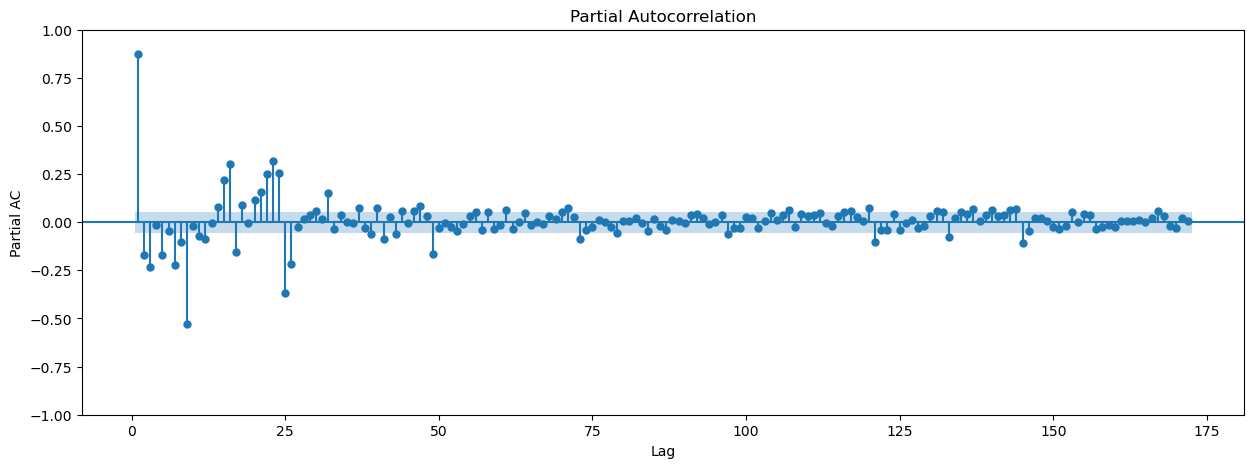

In [51]:
plt.figure(figsize=(15, 5))
plot_pacf(dfs[dfs_names[0]]["total"], lags=172, ax=plt.gca(), method='ywm', alpha=0.05, zero=False)
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

Here I am choosing 172 lags to look at. This is derived from the EDA notebook where we saw deviation from the mean in terms of hour of the day and day of the week, but less in terms of month of the year and year in general. So 172 lags is a week (in terms of hours) and a little bit.

In [52]:
#Creating a function to pull index of lagged values that have highest PACF
def get_lag_index(pacf_values, n=10, confidence_interval=0.05):
    # Calculate absolute PACF values
    abs_pacf = np.absolute(pacf_values)
    
    # Get the indices of the top n+1 values (including the 0th lag which will be removed)
    top_n_indices = np.argpartition(abs_pacf, -n-1)[-n-1:]
    
    # Remove the 0th lag (if it exists) as it's not a lagged value
    top_n_indices = top_n_indices[top_n_indices != 0]
    
    # Filter out indices where PACF value is less than the confidence interval
    top_n_indices = [i for i in top_n_indices if abs_pacf[i] >= confidence_interval]
    
    # Sort the indices to maintain the original order
    top_n_indices.sort()
    
    # Return only the top n indices
    return top_n_indices[:n]

From the previous runs of the parameter search below we can better determine the `indicies_range` that will yield the best results.

In [53]:
#Looping through different time set dataframes and modeling the SARIMAX scores
indices_range = [10, 11]

#looping through all index ranges and time datasets
for n in indices_range:
    #for display to see how loop is running
    print(f'Number of top Indicies: {n}')
    for i, name in enumerate(dfs_names):
        df = dfs[name]
        
        # Grabbing significant lags
        pacf_total = stattools.pacf(df[df['train']]['total'], nlags=172, method='ywm').tolist()

        #saving n number of influential lags
        p_params = get_lag_index(pacf_total, n)

        #for display to see how loop is running
        print(f'{dfs_names[i]}:', end='\r')

        ##Modeling##
        model = SARIMAX(df[df['train']]['total'], order=(p_params, 0, 0), trend="c", enforce_stationarity=False)
        model_fit = model.fit(dsip=False)

        #predicting and saving
        df[f'SARIMAX_predictions_{n}'] = model_fit.predict(start=0, end=len(df))

        #finding the rmse for train and test
        train_rmse = root_mean_squared_error(df[df['train']]['total'], df[f'SARIMAX_predictions_{n}'][df['train']])
        test_rmse = root_mean_squared_error(df[~df['train']]['total'], df[f'SARIMAX_predictions_{n}'][~df['train']])


        ###create rsme dataframe for test and train###
        rmse_df.loc[dfs_names[i], f'SARIMAX_train_{n}'] = format(train_rmse, '.3f')
        rmse_df.loc[dfs_names[i], f'SARIMAX_test_{n}'] = format(test_rmse, '.3f')

    print('RMSE:')
    display(rmse_df)

Number of top Indicies: 10
RMSE:nth:


Baseline_train  Baseline_test SARIMAX_train_10 SARIMAX_test_10
2_month       241.576298     220.590974           78.550         113.454
3_month       235.742804     234.115189           69.735         122.638
10_month      215.074416     250.217809           86.748         236.410

Number of top Indicies: 11
RMSE:nth:


Baseline_train  Baseline_test SARIMAX_train_10 SARIMAX_test_10  \
2_month       241.576298     220.590974           78.550         113.454   
3_month       235.742804     234.115189           69.735         122.638   
10_month      215.074416     250.217809           86.748         236.410   

         SARIMAX_train_11 SARIMAX_test_11  
2_month            76.839         112.723  
3_month            67.211         111.515  
10_month           85.903         236.786

From the parameter search above we want to minsize RMSE while also picking model that will run quickly for every location group we pass in. With that being said, the larger the training data the better the forecast is at predicting father into the future. Meaning the data set given to the model needs to be updated less often to assure good predictions.

<br>From that it appears that a 3 month dataset and 11 of the top most influential lags. Show below are the predictions.

In [54]:
#Plotting best prediction
df = dfs[dfs_names[1]] #picking 3 month period
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[df['train']].index, y=df[df['train']]['total'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=df[~df['train']].index, y=df[~df['train']]['total'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=df['SARIMAX_predictions_11'].index, y=df['SARIMAX_predictions_11'], mode='lines', name="Mean Prediction"))
fig.update_layout(
    yaxis_title="Total number of calls", 
    xaxis_title="Date",
    title="Change in Number of Calls over Prior Hour (total)"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

As a bit deeper dive into the prediction made above it looks as if the most accurate forecasting will be made about a week after then end of the training data. After that we see the model becomes more cautious on its predictions and starts to smooth its predictive curve. This means that the best model for predicting using the above method would need to be undated and retrained every week to predict for the next week. If this model were to be seriously implemented it would need to be someones job to update this model once a week at the end of the week to predict for the next week!

---
### **Differencing:**
Next, we want to see if removing any trend will help the model. Usually this step is conducted if during the decomposition stage we see a uniform trend. However, in our case there wasn't really a consistent trend. Still we will compare and see if it will help the accuracy of the results. As there is a 24 hour cycle in a day we will use that to construct the differencing, meaning we are comparing number of call as compared to the day before and conducting the SARIMAX model on the difference value.

In [55]:
#Removing trend with a 24 hour period of differencing
for i, name in enumerate(dfs_names):
    df = dfs[name]

    #differncing on 24 index period
    df['hourly_difference'] = df['total'].diff(24)

    #dropping starting differences as they will have NaN values
    df.dropna(inplace=True)

    #Repeating decomposition
    decomposition = tsa.seasonal_decompose(df['hourly_difference'], model='additive')

    #adding decomp back in
    df["d_Trend"] = decomposition.trend
    df["d_Seasonal"] = decomposition.seasonal
    df["d_Residual"] = decomposition.resid

#Plotting difference decomp for 1 month dataset
# Create subplots with increased vertical spacing
fig = make_subplots(
    rows=3, cols=1, subplot_titles=cols,
    vertical_spacing=0.1, shared_xaxes=True  # Ensure shared x-axes
)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=dfs[dfs_names[0]].index, y=dfs[dfs_names[0]][col]),
        row=i+1,
        col=1
    )

# Set the range slider to be visible only on the last subplot
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)
fig.update_xaxes(rangeslider_visible=True, row=3, col=1)

fig.update_layout(
    height=900,  # Increase the height to allow space for the range slider
    width=1100,
    showlegend=False,
    title_text="Trend, Seasonal, and Residual Components",
    margin=dict(t=50, b=50)  # Add margin to avoid overlapping with the range slider
)

fig.show()

In [56]:
for n in indices_range:
    print(f'Number of top Indices: {n}')

    for i, name in enumerate(dfs_names):
        df = dfs[name]
        print(f'{dfs_names[i]}:', end='\r')

        # Grabbing significant lags
        pacf_total = stattools.pacf(df[df['train']]['hourly_difference'], nlags=172, method='ywm').tolist()
        p_params = get_lag_index(pacf_total, n)

        # Modeling step
        model = SARIMAX(df[df['train']]['hourly_difference'], order=(p_params, 0, 0), trend="c", enforce_stationarity=False)
        model_fit = model.fit(disp=0)

        # Making predictions
        df[f'SARIMAX_predictions_d{n}'] = model_fit.predict(start=0, end=len(df) - 1)

        # Adding back in differencing
        first_day_indices = df.index[:24]  # 24 here is equal to the period of differencing
        remaining_indices = df.index[24:]

        # Create an empty restored column
        df['restored'] = np.nan

        # Filling in the first 24 original values into the empty restored column
        df.loc[first_day_indices, "restored"] = df.loc[first_day_indices, 'total']

        # Use the current difference value and 24-hour lagged restored value to get the next restored value
        for current_date in remaining_indices:
            current_value = df.loc[current_date, "hourly_difference"]
            previous_restored = df.loc[current_date - pd.DateOffset(hours=24), "restored"]
            df.loc[current_date, "restored"] = previous_restored + current_value

        # use the original train diff values and predicted test values
        df.loc[df[df['train']].index, "AR_difference"] = df[f'SARIMAX_predictions_d{n}'][df['train']]
        df.loc[df[~df['train']].index, "AR_difference"] = df[f'SARIMAX_predictions_d{n}'][~df['train']]

        # empty restored column
        df["AR_restored"] = np.nan

        # fill in the first 12 original values
        df.loc[first_day_indices, "AR_restored"] = df.loc[first_day_indices, "total"]

        # use the current difference and 12-month lagged restored value to get the next restored
        for current_date in remaining_indices:
            current_value = df.loc[current_date, "AR_difference"]
            day_before_restored = df.loc[current_date - pd.DateOffset(hours=24), "AR_restored"]

            df.loc[current_date, "AR_restored"] = day_before_restored + current_value

        # Calculate RMSE for train and test
        train_rmse = root_mean_squared_error(df[df['train']]['total'], df['AR_restored'][df['train']])
        test_rmse = root_mean_squared_error(df[~df['train']]['total'], df['AR_restored'][~df['train']])

        # Create RMSE DataFrame for test and train
        rmse_df.loc[dfs_names[i], f'SARIMAX_train_d{n}'] = format(train_rmse, '.3f')
        rmse_df.loc[dfs_names[i], f'SARIMAX_test_d{n}'] = format(test_rmse, '.3f')

    display(rmse_df)

Number of top Indices: 10


Baseline_train  Baseline_test SARIMAX_train_10 SARIMAX_test_10  \
2_month       241.576298     220.590974           78.550         113.454   
3_month       235.742804     234.115189           69.735         122.638   
10_month      215.074416     250.217809           86.748         236.410   

         SARIMAX_train_11 SARIMAX_test_11 SARIMAX_train_d10 SARIMAX_test_d10  
2_month            76.839         112.723            89.013          123.939  
3_month            67.211         111.515            99.479          127.786  
10_month           85.903         236.786            91.612          130.843

Number of top Indices: 11


Baseline_train  Baseline_test SARIMAX_train_10 SARIMAX_test_10  \
2_month       241.576298     220.590974           78.550         113.454   
3_month       235.742804     234.115189           69.735         122.638   
10_month      215.074416     250.217809           86.748         236.410   

         SARIMAX_train_11 SARIMAX_test_11 SARIMAX_train_d10 SARIMAX_test_d10  \
2_month            76.839         112.723            89.013          123.939   
3_month            67.211         111.515            99.479          127.786   
10_month           85.903         236.786            91.612          130.843   

         SARIMAX_train_d11 SARIMAX_test_d11  
2_month            107.486          130.812  
3_month             99.518          129.203  
10_month            92.745          131.207

In [57]:
#Plotting best prediction
df = dfs[dfs_names[0]] #picking 2 month period
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[df['train']].index, y=df[df['train']]['total'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=df[~df['train']].index, y=df[~df['train']]['total'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=df['SARIMAX_predictions_d10'].index, y=df['AR_restored'], mode='lines', name="Mean Prediction"))
fig.update_layout(
    yaxis_title="Difference number of calls", 
    xaxis_title="Date",
    title="Change in Number of Calls over Prior Hour (total)"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

---
### **Facebook Prophet:**
Next we will be using the new facebook prophet timeseries predictive model. It is supposed to be fast accurate and fully automatic. We will see and compare to Sarimax and differenced SARIMAX.<br>
To learn more about the Facebook Prohpet model and its creation you can read the paper relases by its creators [HERE](https://peerj.com/preprints/3190.pdf).

Before we can use the prophet model we need to organize the data into a specific way.

* **DateTime** - the first column of the dataframe passed in needs to be labeled `ds`
    - This step was done when importing the data at the start of the notebook
* **Value** - the second column which contained the value that will be forecasted needs to be labeled `y`

In [58]:
#creating simple dataset for first round try
df_P1 = pd.DataFrame({'ds':df_hourly.index, 'y':df_hourly['total']})

# Determining the split point
split_index = int(len(df_P1) * 0.8)

# Splitting the dataframe
df_P1_train = df_P1.iloc[:split_index]
df_P1_test = df_P1.iloc[split_index:]

In [59]:
###first basic try with prophet###
# Fit the model
model = Prophet()
model.fit(df_P1_train)

19:46:14 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
forecast = model.predict(df_P1_test[['ds']])

In [61]:
# Calculate RMSE
rmse = root_mean_squared_error(df_P1_test['y'], forecast['yhat'])
print(f"RMSE: {rmse}")

#checking indicies of ds are inline with forecast
#print(df_P1_test['ds'])
#print(forecast['ds'])

RMSE: 187.8798037889284


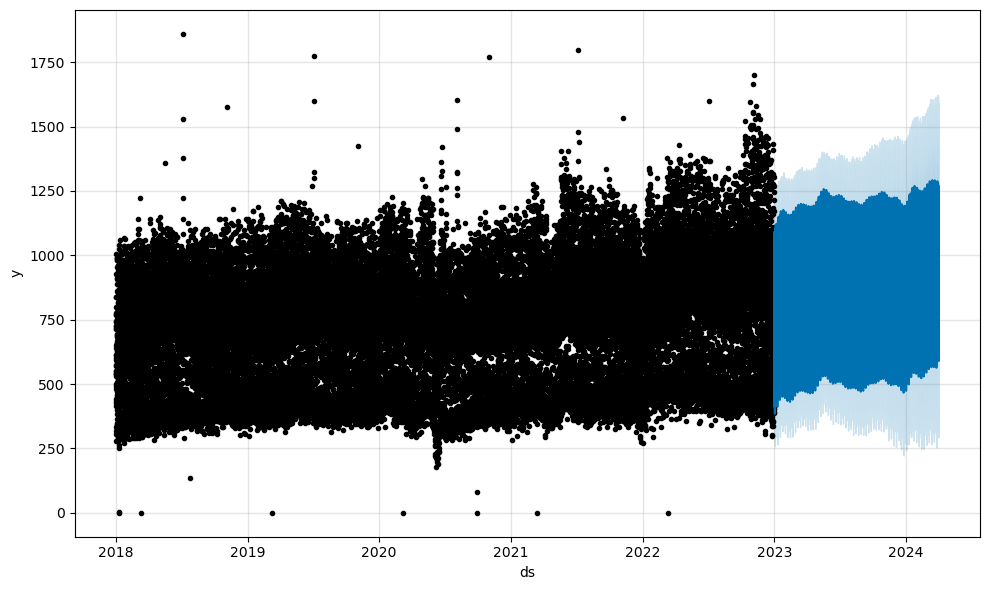

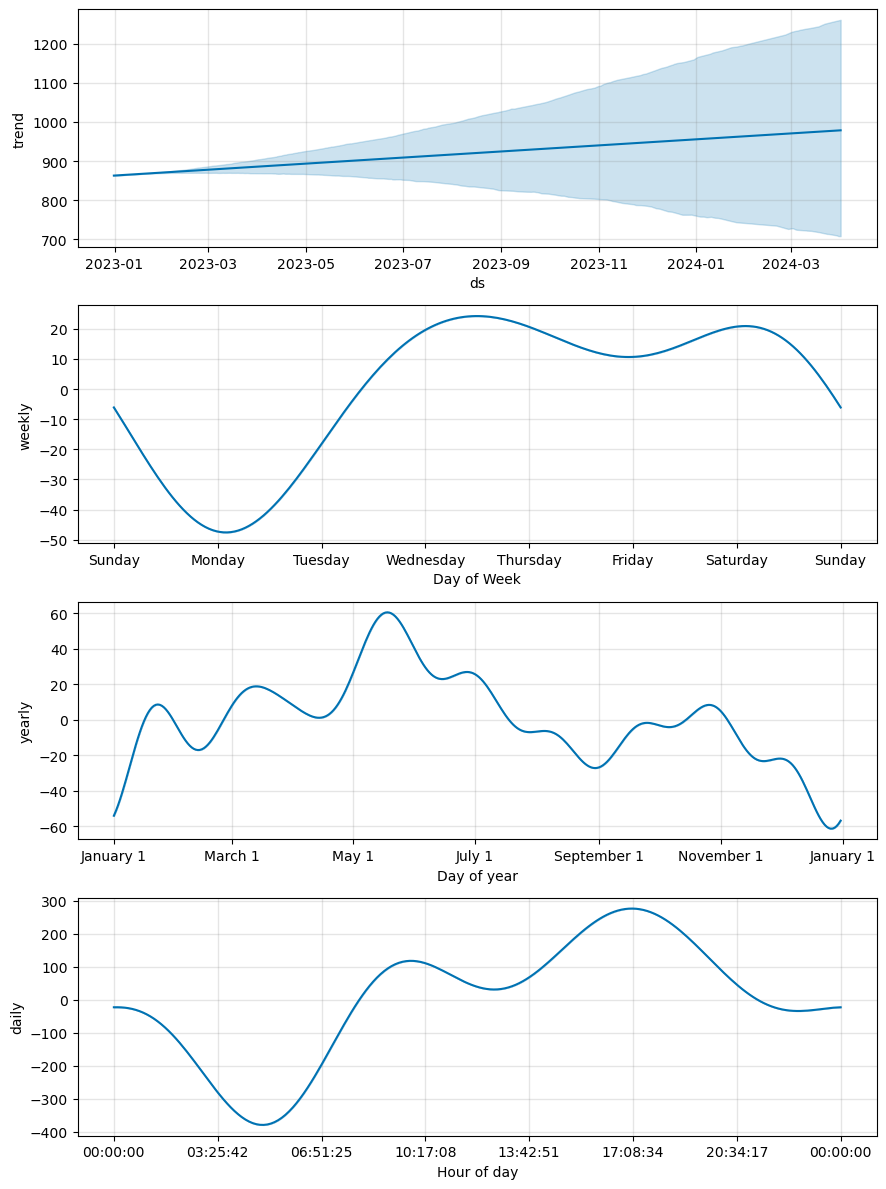

In [62]:
#plotting
fig1 = model.plot(forecast)

fig2 = model.plot_components(forecast)

In [63]:
#more plotting
#plot_plotly(model, forecast)
#don't run crashes too LARGE!

In [64]:
plot_components_plotly(model, forecast)

Above we see a simple application of the prophet forcasting tool. While the RSME is good as compared to the models above it still does not beat the current top predictive model of ~111 so we will try to parameterize the model based on the size of the dataset we are giving prophet to predict on as see if that impoves the model.

In [65]:
for i, name in enumerate(dfs_names):
    df = dfs[name]
    
    #organizing for Prophet readability
    df_P = pd.DataFrame({'ds':df.index, 'y':df['total']})

    # Determining the split point
    split_index = int(len(df_P) * 0.8)
    
    # Splitting the dataframe
    df_P_train = df_P.iloc[:split_index]
    df_P_test = df_P.iloc[split_index:]

    #fitting model
    model = Prophet()
    model.fit(df_P_train)

    #predicting
    forecast = model.predict(df_P[['ds']])
    df['prophet_predictions'] = forecast['yhat'].values
    
    ###scoring###
    # Calculate RMSE for train and test
    train_rmse = root_mean_squared_error(df[df['train']]['total'], df['prophet_predictions'][df['train']])
    test_rmse = root_mean_squared_error(df[~df['train']]['total'], df['prophet_predictions'][~df['train']])

    ##create rsme dataframe for test and train##
    rmse_df.loc[dfs_names[i], 'Prophet_train'] = format(train_rmse, '.3f')
    rmse_df.loc[dfs_names[i], 'Prophet_test'] = format(test_rmse, '.3f')

pd.set_option('display.max_columns', None)
display(rmse_df.T)

19:46:52 - cmdstanpy - INFO - Chain [1] start processing
19:46:52 - cmdstanpy - INFO - Chain [1] done processing
19:46:53 - cmdstanpy - INFO - Chain [1] start processing
19:46:53 - cmdstanpy - INFO - Chain [1] done processing
19:46:54 - cmdstanpy - INFO - Chain [1] start processing
19:46:55 - cmdstanpy - INFO - Chain [1] done processing


2_month     3_month    10_month
Baseline_train     241.576298  235.742804  215.074416
Baseline_test      220.590974  234.115189  250.217809
SARIMAX_train_10       78.550      69.735      86.748
SARIMAX_test_10       113.454     122.638     236.410
SARIMAX_train_11       76.839      67.211      85.903
SARIMAX_test_11       112.723     111.515     236.786
SARIMAX_train_d10      89.013      99.479      91.612
SARIMAX_test_d10      123.939     127.786     130.843
SARIMAX_train_d11     107.486      99.518      92.745
SARIMAX_test_d11      130.812     129.203     131.207
Prophet_train          85.898      84.520      97.435
Prophet_test          111.689     178.085     104.174

In [66]:
#Plotting best prediction
df = dfs[dfs_names[2]] #picking 3 month period

fig = go.Figure()
fig.add_trace(go.Scatter(x=df[df['train']].index, y=df[df['train']]['total'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=df[~df['train']].index, y=df[~df['train']]['total'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=df.index, y=df['prophet_predictions'], mode='lines', name="Mean Prediction"))
fig.update_layout(
    yaxis_title="Difference number of calls", 
    xaxis_title="Date",
    title="Change in Number of Calls over Prior Hour (total)"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [67]:
display(forecast)

ds       trend  yhat_lower   yhat_upper  trend_lower  \
0    2023-06-26 23:00:00  765.792270  617.352406   869.782209   765.792270   
1    2023-06-27 00:00:00  765.748603  617.681345   875.316979   765.748603   
2    2023-06-27 01:00:00  765.704936  572.144858   824.909031   765.704936   
3    2023-06-27 02:00:00  765.661269  477.153026   729.088758   765.661269   
4    2023-06-27 03:00:00  765.617602  344.444428   599.761557   765.617602   
...                  ...         ...         ...          ...          ...   
6680 2024-03-31 07:00:00  854.692487  549.259935   818.310289   799.704055   
6681 2024-03-31 08:00:00  854.747749  684.139543   960.735050   799.805306   
6682 2024-03-31 09:00:00  854.803012  760.122839  1029.867792   799.906557   
6683 2024-03-31 10:00:00  854.858274  757.388581  1031.582855   800.007808   
6684 2024-03-31 11:00:00  854.913537  716.460161   995.372558   800.002291   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      765.792270      -19.345958            -19.345958            -19.345958   
1      765.748603      -20.654175            -20.654175            -20.654175   
2      765.704936      -62.003211            -62.003211            -62.003211   
3      765.661269     -163.672254           -163.672254           -163.672254   
4      765.617602     -300.094227           -300.094227           -300.094227   
...           ...             ...                   ...                   ...   
6680   908.513263     -170.041746           -170.041746           -170.041746   
6681   908.677217      -29.291192            -29.291192            -29.291192   
6682   908.841170       43.427297             43.427297             43.427297   
6683   909.005124       39.525055             39.525055             39.525055   
6684   909.169078       -2.064667             -2.064667             -2.064667   

           daily  daily_lower  daily_upper     weekly  weekly_lower  \
0      18.554604    18.554604    18.554604 -37.900562    -37.900562   
1      15.538405    15.538405    15.538405 -36.192580    -36.192580   
2     -27.636006   -27.636006   -27.636006 -34.367205    -34.367205   
3    -131.240504  -131.240504  -131.240504 -32.431751    -32.431751   
4    -269.699726  -269.699726  -269.699726 -30.394502    -30.394502   
...          ...          ...          ...        ...           ...   
6680 -159.390814  -159.390814  -159.390814 -10.650932    -10.650932   
6681  -16.408807   -16.408807   -16.408807 -12.882385    -12.882385   
6682   58.496485    58.496485    58.496485 -15.069188    -15.069188   
6683   56.733593    56.733593    56.733593 -17.208538    -17.208538   
6684   17.233223    17.233223    17.233223 -19.297890    -19.297890   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0       -37.900562                   0.0                         0.0   
1       -36.192580                   0.0                         0.0   
2       -34.367205                   0.0                         0.0   
3       -32.431751                   0.0                         0.0   
4       -30.394502                   0.0                         0.0   
...            ...                   ...                         ...   
6680    -10.650932                   0.0                         0.0   
6681    -12.882385                   0.0                         0.0   
6682    -15.069188                   0.0                         0.0   
6683    -17.208538                   0.0                         0.0   
6684    -19.297890                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
0                            0.0  746.446312  
1                            0.0  745.094428  
2                            0.0  703.701725  
3                            0.0  601.989014  
4                            0.0  465.523374  
...                          ...         ...  
6680                         0.0  684.650741  
6681              

In [68]:
#saving this run... took a long time
#pd.DataFrame.to_csv(rmse_df, r'C:\Users\cmphi\Documents\BrainStation\DataBases\capstone_911\parameter_search.csv', index=True)

---
# **Model Selection:**
From the long run of parameter searches above, and the many hours before that final search the best model is the Facebook Prophet model for a number of reasons:
1. **RMSE** - The 10 month dataset with the facebook prophet model proved to be the best in terms of rmse with a value of 104.174
    - caveat to this point is that because the datasets are not the same size and have different points the rmse cannot be fully compared between different size datasets. That being said its good enough for me to be confident that that model will be the best.
1. **Run Time** - The Facebook Prophet model takes much... much less time to run even over a larger dataset and will thus be easier to apply to all the columns of the original dataset to create predictive models for each locational granularity.
1. **Autonomy** - The Prophet model is mostly automatic with how it takes its parameters meaning that over "different" datasets as in the different locational columns being passed into it, I trust more that the model will be able to accurately pick up the underlying trends that each precinct may have.

With all the above being said, and again because the model is so fast I will do another parameter search to determine what the best size dataset will be to pass into the model. I plan to do this by simply passing every month as the range of possible series sizes and see which works best. Current the winner is 10 months, but for all we know at this stage 73 months might be incredible at predicting... so we test again.

In [69]:
# Find out how many months are in the dataset
first_index = df_hourly.index.min()
last_index = df_hourly.index.max()
num_months = (last_index.year - first_index.year) * 12 + (last_index.month - first_index.month) + 1

# List of time scales in months
time_scales = list(range(1, num_months + 1))  # Including the full range

# Initialization
dfs = {}
dfs_names = []
hours_per_month = 24 * 7 * 4

# Create DataFrames for each time scale
for n in time_scales:
    # Generate the DataFrame for each time scale
    df_name = f"{n}_month"
    start_date = last_index - pd.DateOffset(months=n)
    dfs[df_name] = df_hourly.loc[start_date:]
    dfs_names.append(df_name)

# Adding full dataset
dfs['full'] = df_hourly
dfs_names.append('full')

In [70]:
# Initialize the DataFrame to store RMSE values
rmse_df = pd.DataFrame(index=dfs_names, columns=['train', 'test'])

for i, name in enumerate(dfs_names):
    df = dfs[name].copy()
    
    # Organizing for Prophet readability
    df_P = pd.DataFrame({'ds': df.index, 'y': df['total']})
    
    # Determining the split point
    split_index = int(len(df_P) * 0.8)
    
    # Splitting the dataframe
    df_P_train = df_P.iloc[:split_index]
    df_P_test = df_P.iloc[split_index:]

    # Fitting model
    model = Prophet()
    model.fit(df_P_train)

    # Predicting
    forecast = model.predict(df_P[['ds']])
    df['prophet_predictions'] = forecast['yhat'].values
    
    # Calculate RMSE for train and test
    train_rmse = root_mean_squared_error(df_P_train['y'], df['prophet_predictions'].iloc[:split_index])
    test_rmse = root_mean_squared_error(df_P_test['y'], df['prophet_predictions'].iloc[split_index:])

    # Store RMSE in the dataframe
    rmse_df.loc[name, 'train'] = format(train_rmse, '.3f')
    rmse_df.loc[name, 'test'] = format(test_rmse, '.3f')

display(rmse_df.sort_values(by='test', ascending=True))

19:46:58 - cmdstanpy - INFO - Chain [1] start processing
19:46:58 - cmdstanpy - INFO - Chain [1] done processing
19:46:59 - cmdstanpy - INFO - Chain [1] start processing
19:46:59 - cmdstanpy - INFO - Chain [1] done processing
19:47:00 - cmdstanpy - INFO - Chain [1] start processing
19:47:00 - cmdstanpy - INFO - Chain [1] done processing
19:47:01 - cmdstanpy - INFO - Chain [1] start processing
19:47:02 - cmdstanpy - INFO - Chain [1] done processing
19:47:03 - cmdstanpy - INFO - Chain [1] start processing
19:47:03 - cmdstanpy - INFO - Chain [1] done processing
19:47:05 - cmdstanpy - INFO - Chain [1] start processing
19:47:06 - cmdstanpy - INFO - Chain [1] done processing
19:47:07 - cmdstanpy - INFO - Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing
19:47:09 - cmdstanpy - INFO - Chain [1] start processing
19:47:10 - cmdstanpy - INFO - Chain [1] done processing
19:47:11 - cmdstanpy - INFO - Chain [1] start processing
19:47:12 - cmdstanpy - INFO - Chain [1]

train     test
9_month    97.199  104.535
1_month    89.687  104.596
31_month  119.998  104.779
7_month    93.906  104.966
32_month  119.714  106.249
...           ...      ...
72_month  108.379  184.452
75_month  107.109  187.880
full      107.109  187.880
74_month  107.604  188.685
73_month  108.028  189.287

[76 rows x 2 columns]

Yay!! look at that, after running the above function the `9 month` window retained a ~104 RMSE score each time being at the top of the list. This will be the time scale of the data we will leave as a default for the function that passes through each locational granularity.

---
# **Final Predictions:**

In this next and final step we will be creating a function that loops through each column in the original dataframe and creates a new predictive model for each locational granularity. The output will then be saved as to be used in a visualization notebook and then a public Streamlit app.

In [71]:
#creating function to take database and create predictions
def forecasting_911(df, time_scale=9):
    """
    Generate predictions for a given DataFrame using a specified time scale.

    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with numeric values and a datetime index.
    time_scale : int, optional
        The time scale for the predictive model in months. Default is 3 months.

    Returns
    -------
    predictions_dict
        A dictionary of pandas.DataFrames filled with values from the Facebook Prophet forecasting model
    """

    ## Initializing steps ##
    hours_per_month = 24 * 7 * 4
    last_index = df.index.max() #setting the most recent data point
    cols = df.columns # Creating list of columns to predict on
    output_dict = {} # Initializing output dictionary
    output_dict['scores'] = pd.DataFrame()
    
    
    # Putting true values into output_dict
        # -Needs to happen here so all the data is available for visualization later
    for col in cols:
        output_dict[col] = pd.DataFrame({'ds':df.index, 'yhat':df[col].values, 'yhat_lower':df[col].values, 'yhat_upper':df[col].values, 'quality':0})
    

    ## Actions that don't need to happen within the model loops ##
        # -Doing these here will save on some runtime
    # Setting the time scale
    df = df.loc[(df.index >= (last_index - timedelta(hours=(time_scale * hours_per_month))))]

    # Determining the training split point
    split_index = int(len(df) * 0.8)


    ## Main loop to make predictions for every locational column ##
    for col in cols:
        ## 0: Base line model metric for each column ##
            # -Run to grab score of prediction to be made by round 1

        # Organizing for Prophet readability
        Prophet_df = pd.DataFrame({'ds':df.index, 'y':df[col].values})

        # Splitting the dataframe
        df_train = Prophet_df.iloc[:split_index]
        df_test = Prophet_df.iloc[split_index:]

        # Fitting model
        model = Prophet()
        model.fit(df_train)

        # Predicting
        forecast = model.predict(Prophet_df[['ds']])

        # Calculating and saving MAPE scores
        rmse = root_mean_squared_error(df_test['y'], forecast['yhat'][split_index:])
        rmse_df = pd.DataFrame({'location':[col], 'rmse':[rmse]})
        output_dict['scores'] = pd.concat([output_dict['scores'], rmse_df], ignore_index=True)



        ## 1: First future forecast past available data ##
            # -Predictions will not be testable but can be comparable to the baseline model metric

        # Organizing for Prophet readability
        Prophet_df = pd.DataFrame({'ds':df.index, 'y':df[col].values})

        # Training model on whole range of data
        model = Prophet()
        model.fit(Prophet_df) 

        # Forecasting
        future = model.make_future_dataframe(periods=len(df_test), freq='H')
        forecast = model.predict(future)
        forecast['quality'] = 1
        
        # Storing the predictions in the output dictionary
        output_dict[col] = pd.concat([output_dict[col], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'quality']]], ignore_index=True)



        ## 2: Second Future forecast ##
            # -Predictions are made using predictions, this meaning they can't be fully evaluated for error
            # -Farthest forecast willing to make, we can call this a soft prediction

        # Organizing for Prophet readability
        Prophet_df = pd.DataFrame({'ds':output_dict[col]['ds'], 'y':output_dict[col]['yhat']})
        last_index = Prophet_df['ds'].max()
        Prophet_df = Prophet_df.loc[(Prophet_df['ds'] >= (last_index - timedelta(hours=(time_scale * hours_per_month))))]

        #Training model on forecasted values         
        model = Prophet()
        model.fit(Prophet_df)

        # Forecasting
        future = model.make_future_dataframe(periods=len(df_test), freq='H')
        forecast = model.predict(future)
        forecast['quality'] = 2
        
        # Storing the predictions in the output dictionary
        output_dict[col] = pd.concat([output_dict[col], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'quality']]], ignore_index=True)


    #outputs
    if __name__ == "__main__":
        #plotting scores
        fig = px.bar(output_dict['scores'], x='location', y='rmse')
        fig.update_layout(yaxis_type="log")
        fig.show()
        # print(tabulate(df, headers='keys', tablefmt='psql')) #best is not run in notebook

    return output_dict

In [72]:
output_dict = forecasting_911(df_hourly)

20:08:47 - cmdstanpy - INFO - Chain [1] start processing
20:08:47 - cmdstanpy - INFO - Chain [1] done processing
20:08:49 - cmdstanpy - INFO - Chain [1] start processing
20:08:51 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:56 - cmdstanpy - INFO - Chain [1] done processing
20:08:58 - cmdstanpy - INFO - Chain [1] start processing
20:08:58 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing
20:09:03 - cmdstanpy - INFO - Chain [1] start processing
20:09:07 - cmdstanpy - INFO - Chain [1] done processing
20:09:09 - cmdstanpy - INFO - Chain [1] start processing
20:09:10 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:12 - cmdstanpy - INFO - Chain [1] done processing
20:09:14 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1]

In [73]:
output_dict['scores']

location        rmse
0               1    6.549491
1               5    3.527881
2               6    3.282335
3               7    3.343227
4               9    3.205772
..            ...         ...
78       BROOKLYN   40.909308
79      MANHATTAN   41.109343
80         QUEENS   23.026644
81  STATEN ISLAND    7.626596
82          total  106.772812

[83 rows x 2 columns]

Great it looks to be working perfectly!! The distribution in RMSE is due to the volumne of calls, with the locations getting more calls having on average a higher as there is more room for forecasting deviation. The point to note here is the total is ~106 which is around the tested ~104 range for 9 month sets.

These scores are used to say the RMSE for prediction quality 1 will mostly be in line with the graph above. While the quality 2 predictions are predictions made off quality 1 predictions meaning they are less accurate.

In [74]:
# save forecast dictionary to forecast_3-31-2024.pkl file
with open('forecast_3-31-2024.pkl', 'wb') as fp:
    pickle.dump(output_dict, fp)
    print('dictionary saved successfully to file')

#Example how to read:
'''
with open('forecast_3-31-2024.pkl', 'rb') as fp:
    output_dict = pickle.load(fp)
    print('Output Dictionary')
    print(output_dict)
'''

dictionary saved successfully to file


"\nwith open('forecast_3-31-2024.pkl', 'rb') as fp:\n    output_dict = pickle.load(fp)\n    print('Output Dictionary')\n    print(output_dict)\n"

### **Future State:**

In the future I would like to work with more of the Prophet built in diagnostics and cross validations techniques to help improve the predictive ability of this model. [HERE](https://facebook.github.io/prophet/docs/diagnostics.html) is where to go to do a deeper dive into how to better evaluate, predict and hyper-parameterize the prophet model.